In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from src.models.frontier import MultiStockEnv, Agent, backtest, maybe_make_dir
from src.config import market_tickers
from src.config.model_config import model_parameters

CPU times: user 5.07 s, sys: 3.24 s, total: 8.32 s
Wall time: 2.52 s


In [2]:
# papermill parameters
SEED_LIST = [
             0,
             #1111,
             #2222, 
             #3333, 
             #4444, 
             #5555,
             #6666,
             #7777,
             #8888,
             #9999
            ]

#TICKERS = market_tickers.DOW_30_TICKER
TICKERS = ['AAPL', 'AMD', 'CSCO', 'F', 'INTC']
MARKET_NAME = 'TEST_5'
MODEL_BASE_NAME = 'RL_CNN' # use either | 'RL_CNN' | 'RL_str_fcast' | 'RL_all_inp' |
FROM = '2019-01-01' # start of backtest
UNTIL = '2020-01-01' # end of backtest
NB_EPISODES = 200 # backtest model that was trained for this number of episodes

# investor preferences
GAMMA_TRADES = [0.1, 1, 10, 100]
GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
GAMMA_HOLDS = [0.1, 1]

In [3]:
# Parameters
SEED_LIST = [0]
TICKERS = ["AAPL", "AMD", "CSCO", "F", "INTC"]
MARKET_NAME = "TEST_5"
MODEL_BASE_NAME = "RL_CNN"
FROM = "2019-01-01"
UNTIL = "2020-01-01"
NB_EPISODES = 200
GAMMA_TRADES = [0.1, 1, 10, 100]
GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
GAMMA_HOLDS = [0.1, 1]


In [4]:
#------ small test-sweep ------#
# GAMMA_TRADES = [0.1, 1, 10, 100]
# GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
# GAMMA_HOLDS = [0.1, 1]
#------ extended-boyd-sweep ------#
# GAMMA_TRADES =  [0.1, 0.5, 1, 2, 3, 4, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 11, 12, 15, 20, 30, 45, 60, 100, 200]
# GAMMA_RISKS = [0.1, 0.178, 0.316, 0.562, 1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000, 2000, 5000, 10000, 20000]
#---------------------------------#

GAMMA_TRIOS = []
for tr in GAMMA_TRADES:
    for ri in GAMMA_RISKS:
        for hd in GAMMA_HOLDS:
            GAMMA_TRIOS.append((tr, ri, hd))
        
#format: (gamma_trade, gamma_risk, gamma_hold)
print('number of trios: ', len(GAMMA_TRIOS))
#GAMMA_TRIOS

number of trios:  40


In [5]:
# other constants and parameters
TICKERS.sort()
FILE_PERIOD = '1d' # weekly='5d', daily='1d'
HALF_SPREAD = 0.0005/2.0 # 'a' in transaction cost function
NONLIN_COEFF = 1.0 # 'b' transaction cost function
POWER = 1.5 # power for change in poertfolio vector used in transaction cost
INIT_PORTFOLIO = 100000000.0 # initial portfolio value

USE_FORECASTS = model_parameters[MODEL_BASE_NAME]['use_forecasts'] # whether to use forecasts as inputs to agent policy net or not
NB_FORECASTS = model_parameters[MODEL_BASE_NAME]['nb_forecasts'] # number of forecasts to use in state. Set to None for no forecasts
FORECAST_TYPE = model_parameters[MODEL_BASE_NAME]['forecast_type'] # use 'strong' or 'weak' forecasts (if no forecasts given, this does not matter)
USE_CNN_STATE = model_parameters[MODEL_BASE_NAME]['use_cnn_state'] # whether to pass log-rets block for CNN part of policy net (set to false for forecast only)

TEST_NAME = f'{MARKET_NAME}_{MODEL_BASE_NAME}_seeds_{SEED_LIST[0]}_etc'
RESULTS_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/backtests/'
DATA_DIR = f'../data/{MARKET_NAME}/preprocessed_data/'

## create agent(s) and backtest in new backtest env

In [6]:
%%time
# make directory for results if it does not exist already
maybe_make_dir(RESULTS_DIR)

print('creating environment and agent...')
env = MultiStockEnv(tickers=TICKERS, 
                    from_date=FROM,
                    until=UNTIL, 
                    #nb_episodes=100,
                    cash_key='USDOLLAR', 
                    #gamma_risk=GAMMA_RISK, 
                    #gamma_trade=GAMMA_TRADE,
                    #half_spread=HALF_SPREAD, 
                    nonlin_coef=NONLIN_COEFF, 
                    power=POWER, 
                    datadir=DATA_DIR, 
                    state_lookback_window=20, 
                    #distribution=EPISODE_DRAW_DISTRIBUTION,
                    #days_duration=DAYS_IN_EPISODE, 
                    mode='backtest', 
                    random_seed=7,
                    init_portfolio=INIT_PORTFOLIO, 
                    period_in_file_name=FILE_PERIOD, 
                    nb_forecasts=NB_FORECASTS, 
                    forecast_type=FORECAST_TYPE,
                    use_CNN_state=USE_CNN_STATE,
                    verbose=False)

agent = Agent(alpha=0.001, 
              gamma=0.99, 
              n_assets=len(TICKERS)+1, 
              tau=5, 
              lookback_window=20, 
              n_feature_maps=len(TICKERS)+1,
              use_forecasts=USE_FORECASTS,
              use_CNN_state=USE_CNN_STATE,
              allow_long_short_trades=True)

results_dict = {}
#actions_dict = {}
print('backtesting:')

total_backtests = len(SEED_LIST) * len(GAMMA_TRIOS)
backtest_counter = 0

for RANDOM_SEED in SEED_LIST:
    for (GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD) in GAMMA_TRIOS:
        
        backtest_counter += 1
        print(f'\t[{backtest_counter}/{total_backtests}]\t{MODEL_BASE_NAME}: gamma_trade={GAMMA_TRADE}, gamma_risk={GAMMA_RISK}, gamma_hold={GAMMA_HOLD}, seed={RANDOM_SEED}...')
        
        # load trained RL model for backtesting
        SAVED_MODEL_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}/models/{MODEL_BASE_NAME}_seed_{RANDOM_SEED}_{NB_EPISODES}'
        # set dir where actions csv file will be saved
        actions_dir = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}'
        
        try:
            rl_rets, rl_actions = backtest(agent, env, weights_file_dir=SAVED_MODEL_DIR, verbose=False)
            
            #rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[1:].index)
            #rl_actions = pd.DataFrame(data=rl_actions, index=env.returns.loc[FROM:UNTIL].iloc[0:].index, columns=TICKERS+['USDOLLAR'])
            rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[:-1].index)
            rl_rets = rl_rets.shift(1)
            rl_rets.iloc[0] = 0
            rl_actions = pd.DataFrame(data=rl_actions[:-1], index=env.returns.loc[FROM:UNTIL].iloc[:-1].index, columns=TICKERS+['USDOLLAR'])
            
            # save actions
            rl_actions.to_csv(f'{actions_dir}/actions.csv')
            #print('actions saved.')

            cash_rets = env.returns.loc[FROM:UNTIL, env.cash_key].iloc[:-1]
            excess_rets = rl_rets - cash_rets

            R_e = excess_rets.mean() * 100 * 252
            sigma_e = excess_rets.std() * 100 * np.sqrt(252)
            sharpe = R_e / sigma_e

            results_dict[(GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD, RANDOM_SEED)] = {'excess_return':R_e, 'excess_risk':sigma_e, 'sharpe':sharpe}
        except Exception as e:
            print(f'**error for model: trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}')
            #print(e)

creating environment and agent...


backtesting:
	[1/40]	RL_CNN: gamma_trade=0.1, gamma_risk=0.1, gamma_hold=0.1, seed=0...


	[2/40]	RL_CNN: gamma_trade=0.1, gamma_risk=0.1, gamma_hold=1, seed=0...


	[3/40]	RL_CNN: gamma_trade=0.1, gamma_risk=1, gamma_hold=0.1, seed=0...


	[4/40]	RL_CNN: gamma_trade=0.1, gamma_risk=1, gamma_hold=1, seed=0...


	[5/40]	RL_CNN: gamma_trade=0.1, gamma_risk=10, gamma_hold=0.1, seed=0...


	[6/40]	RL_CNN: gamma_trade=0.1, gamma_risk=10, gamma_hold=1, seed=0...


	[7/40]	RL_CNN: gamma_trade=0.1, gamma_risk=100, gamma_hold=0.1, seed=0...


	[8/40]	RL_CNN: gamma_trade=0.1, gamma_risk=100, gamma_hold=1, seed=0...


	[9/40]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[10/40]	RL_CNN: gamma_trade=0.1, gamma_risk=1000, gamma_hold=1, seed=0...


	[11/40]	RL_CNN: gamma_trade=1, gamma_risk=0.1, gamma_hold=0.1, seed=0...


	[12/40]	RL_CNN: gamma_trade=1, gamma_risk=0.1, gamma_hold=1, seed=0...


	[13/40]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=0.1, seed=0...


	[14/40]	RL_CNN: gamma_trade=1, gamma_risk=1, gamma_hold=1, seed=0...


	[15/40]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=0.1, seed=0...


	[16/40]	RL_CNN: gamma_trade=1, gamma_risk=10, gamma_hold=1, seed=0...


	[17/40]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=0.1, seed=0...


	[18/40]	RL_CNN: gamma_trade=1, gamma_risk=100, gamma_hold=1, seed=0...


	[19/40]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[20/40]	RL_CNN: gamma_trade=1, gamma_risk=1000, gamma_hold=1, seed=0...


	[21/40]	RL_CNN: gamma_trade=10, gamma_risk=0.1, gamma_hold=0.1, seed=0...


	[22/40]	RL_CNN: gamma_trade=10, gamma_risk=0.1, gamma_hold=1, seed=0...


	[23/40]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=0.1, seed=0...


	[24/40]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=1, seed=0...


	[25/40]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=0.1, seed=0...


	[26/40]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=1, seed=0...


	[27/40]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=0.1, seed=0...


	[28/40]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=1, seed=0...


	[29/40]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[30/40]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=1, seed=0...


	[31/40]	RL_CNN: gamma_trade=100, gamma_risk=0.1, gamma_hold=0.1, seed=0...


	[32/40]	RL_CNN: gamma_trade=100, gamma_risk=0.1, gamma_hold=1, seed=0...


	[33/40]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=0.1, seed=0...


	[34/40]	RL_CNN: gamma_trade=100, gamma_risk=1, gamma_hold=1, seed=0...


	[35/40]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=0.1, seed=0...


	[36/40]	RL_CNN: gamma_trade=100, gamma_risk=10, gamma_hold=1, seed=0...


	[37/40]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=0.1, seed=0...


	[38/40]	RL_CNN: gamma_trade=100, gamma_risk=100, gamma_hold=1, seed=0...


	[39/40]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[40/40]	RL_CNN: gamma_trade=100, gamma_risk=1000, gamma_hold=1, seed=0...


CPU times: user 2min 36s, sys: 295 ms, total: 2min 37s
Wall time: 2min 36s


In [7]:
results_df = pd.DataFrame(results_dict).T.reset_index()
results_df.columns = ['gamma_trade', 'gamma_risk', 'gamma_hold', 'seed', 'excess_return', 'excess_risk', 'sharpe']
results_df.to_csv(RESULTS_DIR+TEST_NAME+'.csv', index=False)
print('saved.')
results_df

saved.


,gamma_trade,gamma_risk,gamma_hold,seed,excess_return,excess_risk,sharpe
0,0.1,0.1,0.1,0,2.718739e+01,1.761081e+01,1.543790
1,0.1,0.1,1.0,0,-1.219422e+02,1.543359e+02,-0.790109
2,0.1,1.0,0.1,0,-1.950348e+03,1.343302e+03,-1.451906
3,0.1,1.0,1.0,0,4.250394e+01,2.959198e+01,1.436333
4,0.1,10.0,0.1,0,-2.442963e+00,1.448092e+01,-0.168702
5,0.1,10.0,1.0,0,-1.405291e+00,1.440491e+01,-0.097556
6,0.1,100.0,0.1,0,9.700884e+00,1.351821e+01,0.717616
7,0.1,100.0,1.0,0,9.306340e+00,1.344444e+01,0.692207
8,0.1,1000.0,0.1,0,8.314557e+01,6.466828e+02,0.128572
9,0.1,1000.0,1.0,0,-1.868056e+07,1.861565e+07,-1.003487


(-10.0, 70.0)

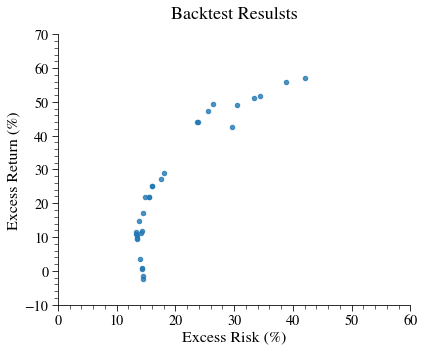

In [8]:
# risk-return plot 
results_df[['excess_return', 'excess_risk']]\
    .rename(
        columns={
            'excess_return':'Excess Return (%)', 
            'excess_risk':'Excess Risk (%)'
        })\
    .plot(
        kind='scatter', 
        x='Excess Risk (%)', 
        y='Excess Return (%)', 
        title='Backtest Resulsts', 
        alpha=0.8,
        figsize=(6,5),
        c='C0')

# x and y axis limits
plt.xlim(left=0.0, right=60.0)
plt.ylim(bottom=-10.0, top=70.0)

In [9]:
print(f'done backtesting for {MODEL_BASE_NAME}.')

done backtesting for RL_CNN.


In [10]:
agent.policy